In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-notes/Indian Currency Dataset/test/fake/test (24).jpg
/kaggle/input/fake-and-real-notes/Indian Currency Dataset/test/fake/test (34).jpg
/kaggle/input/fake-and-real-notes/Indian Currency Dataset/test/fake/test (58).jpg
/kaggle/input/fake-and-real-notes/Indian Currency Dataset/test/fake/test (23).jpg
/kaggle/input/fake-and-real-notes/Indian Currency Dataset/test/fake/ss.jpg
/kaggle/input/fake-and-real-notes/Indian Currency Dataset/test/fake/test (16).jpg
/kaggle/input/fake-and-real-notes/Indian Currency Dataset/test/fake/g-1-380x214.jpg
/kaggle/input/fake-and-real-notes/Indian Currency Dataset/test/fake/test (51).jpg
/kaggle/input/fake-and-real-notes/Indian Currency Dataset/test/fake/1018170-rs-500.jpg
/kaggle/input/fake-and-real-notes/Indian Currency Dataset/test/fake/test (50).jpg
/kaggle/input/fake-and-real-notes/Indian Currency Dataset/test/fake/test (27).jpg
/kaggle/input/fake-and-real-notes/Indian Currency Dataset/test/fake/test (47).jpg
/kaggle/input/fa

In [4]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from glob import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import os
import imageio.v2 as imageio
import imgaug.augmenters as iaa
from PIL import Image
import math

In [6]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-20,20)),
    iaa.GaussianBlur(sigma=(0,1.0))
])

In [7]:
def augment(input_dir,output_dir,num_augmented_images=5):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith(('.jpg','jpeg','.png')):
            image_path = os.path.join(input_dir,filename)
            image = imageio.imread(image_path)
            for i in range(num_augmented_images):
                augmented_image = seq(image=image)
                new_filename = f"{os.path.splitext(filename)[0]}_aug_{i}.jpg"
                new_image_path = os.path.join(output_dir, new_filename)

                pil_image = Image.fromarray(augmented_image)
                if pil_image.mode =="RGBA":
                    pil_image = pil_image.convert("RGB")
                pil_image.save(new_image_path,'JPEG')


train_real_dir = '/kaggle/input/fake-and-real-notes/Indian Currency Dataset/train/real'
train_fake_dir = '/kaggle/input/fake-and-real-notes/Indian Currency Dataset/train/fake'
test_real_dir = '/kaggle/input/fake-and-real-notes/Indian Currency Dataset/test/real'
test_fake_dir = '/kaggle/input/fake-and-real-notes/Indian Currency Dataset/test/fake'

In [8]:
train_real_out_dir = '/kaggle/working/Indian Currency Dataset/train/real'
train_fake_out_dir = '/kaggle/working/Indian Currency Dataset/train/fake'
test_real_out_dir = '/kaggle/working/Indian Currency Dataset/test/real'
test_fake_out_dir = '/kaggle/working/Indian Currency Dataset/test/fake'

In [9]:
augment(train_real_dir, train_real_out_dir)
augment(train_fake_dir, train_fake_out_dir)
augment(test_real_dir, test_real_out_dir)
augment(test_fake_dir, test_fake_out_dir)

In [10]:
IMAGE_SIZE = [224,224]
train_path = "/kaggle/working/Indian Currency Dataset/train"
valid_path = "/kaggle/working/Indian Currency Dataset/test"

In [11]:
folders=glob(train_path+"/*")

In [12]:
folders

['/kaggle/working/Indian Currency Dataset/train/fake',
 '/kaggle/working/Indian Currency Dataset/train/real']

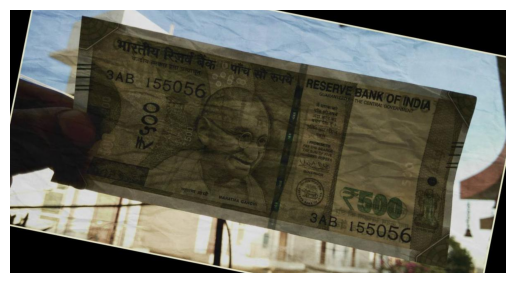

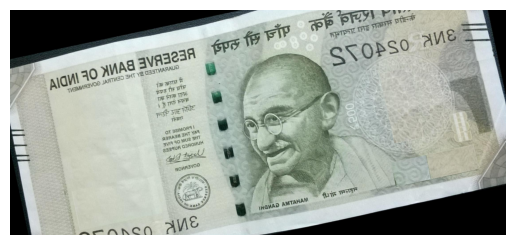

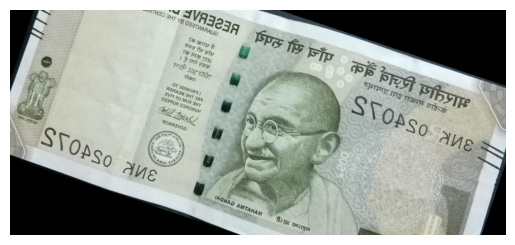

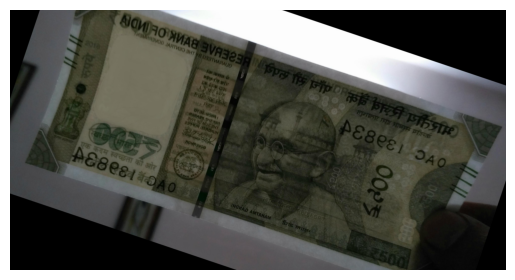

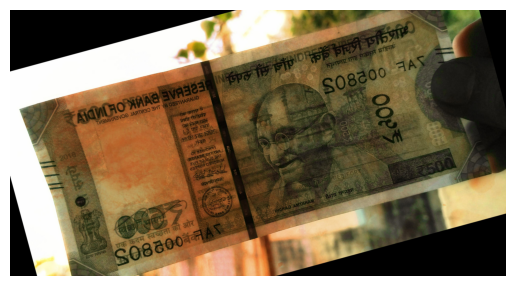

In [13]:
train_image_files = glob(os.path.join(train_path,"*/*.jpg"))
n = 5
for img_path in train_image_files[:n]:
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [14]:
datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
train_set = datagen.flow_from_directory(train_path, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]), batch_size=32, class_mode='categorical')
valid_set = datagen.flow_from_directory(valid_path, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]), batch_size=32, class_mode='categorical')


Found 715 images belonging to 2 classes.
Found 350 images belonging to 2 classes.


In [16]:
base_model = MobileNet(weights ="imagenet",include_top = False )

<ipython-input-16-da411ffeb4e7>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights ="imagenet",include_top = False )


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
preds = Dense(len(folders), activation="softmax")(x)


In [18]:

model = Model(inputs=base_model.input, outputs=preds)

In [19]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
hist = model.fit(train_set,validation_data = valid_set,epochs = 6,steps_per_epoch=len(train_set), validation_steps=len(valid_set)) 

Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7358 - loss: 0.4483 - val_accuracy: 0.6429 - val_loss: 0.4817
Epoch 2/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/6


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 447ms/step - accuracy: 0.9690 - loss: 0.0831 - val_accuracy: 0.7800 - val_loss: 0.3315
Epoch 4/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 440ms/step - accuracy: 0.9982 - loss: 0.0221 - val_accuracy: 0.9400 - val_loss: 0.1498
Epoch 6/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


In [21]:
model.save("fake_currrecy_detection.h5")

In [22]:

import tensorflow as tf

loaded_model = tf.keras.models.load_model('/kaggle/working/fake_currrecy_detection.h5')

In [23]:
test_image_path = '/kaggle/input/real-gandhi/gandhu.jpg'  

test_img = image.load_img(test_image_path, target_size=IMAGE_SIZE)
test_img_array = image.img_to_array(test_img)
test_img_array = np.expand_dims(test_img_array, axis=0)  

test_img_array = test_img_array / 255.0

predictions = loaded_model.predict(test_img_array)

class_labels = ['Fake', 'Real']

predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", predicted_class_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Fake


In [24]:
datagen = ImageDataGenerator(rescale = 1./255)

train_set = datagen.flow_from_directory(train_path, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]), batch_size=32, class_mode='binary')
valid_set = datagen.flow_from_directory(valid_path, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]), batch_size=32, class_mode='binary')



Found 715 images belonging to 2 classes.
Found 350 images belonging to 2 classes.


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    #Conv2D(128, (3, 3), activation='relu'),
    #MaxPooling2D((2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(train_set, epochs=5, validation_data=valid_set)

model.save("cnn_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 120)                 │      11,197,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,202,769 (42.74 MB)

 Trainable params: 11,202,769 (42.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.6217 - loss: 1.2071 - val_accuracy: 0.8114 - val_loss: 0.4041
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 424ms/step - accuracy: 0.8119 - loss: 0.3796 - val_accuracy: 0.8571 - val_loss: 0.3865
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 412ms/step - accuracy: 0.9175 - loss: 0.2093 - val_accuracy: 0.9029 - val_loss: 0.2410
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 405ms/step - accuracy: 0.9687 - loss: 0.0987 - val_accuracy: 0.8886 - val_loss: 0.2644
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 405ms/step - accuracy: 0.9874 - loss: 0.0607 - val_accuracy: 0.9086 - val_loss: 0.2713


In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_set, epochs=5, validation_data=valid_set)

model.save("resnet_model.h5")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 909ms/step - accuracy: 0.6542 - loss: 0.6401 - val_accuracy: 0.7400 - val_loss: 0.5322
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 438ms/step - accuracy: 0.7333 - loss: 0.5407 - val_accuracy: 0.7629 - val_loss: 0.4689
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 435ms/step - accuracy: 0.7421 - loss: 0.4818 - val_accuracy: 0.6714 - val_loss: 0.5767
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - accuracy: 0.7041 - loss: 0.5414 - val_accuracy: 0.7629 - val_loss: 0.4178
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 441ms/step - accuracy: 0.8038 - loss: 0.4521 - val_accuracy: 0.7343 - val_loss: 0.4481


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


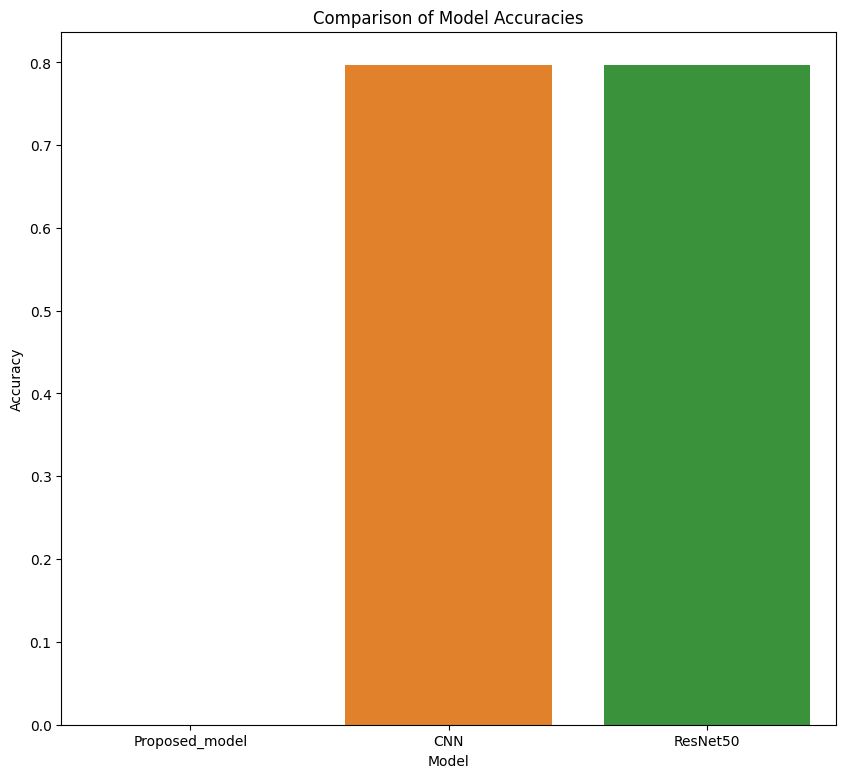

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

mobile_acc = hist.history['accuracy'][-1]  
cnn_acc = history.history['accuracy'][-1]  
resnet_acc = history.history['accuracy'][-1]
data = {
    'Model': ['Proposed_model', 'CNN', 'ResNet50'],
    'Accuracy': [mobile_acc, cnn_acc, resnet_acc]
}

plt.figure(figsize=(10, 9))  
sns.barplot(x='Model', y='Accuracy', data=data)

plt.title('Comparison of Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')


plt.show()

In [28]:
datagen = ImageDataGenerator(rescale = 1./255)
train_set = datagen.flow_from_directory(train_path, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]), batch_size=32, class_mode='categorical')
valid_set = datagen.flow_from_directory(valid_path, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]), batch_size=32, class_mode='categorical')


Found 715 images belonging to 2 classes.
Found 350 images belonging to 2 classes.


In [29]:
base_model = MobileNetV2(weights ="imagenet",include_top = False )

<ipython-input-29-400162500c53>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights ="imagenet",include_top = False )


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [30]:
from tensorflow.keras.layers import Dropout

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x) 
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x) 
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  
preds = Dense(2, activation="softmax")(x)


In [31]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_set.labels, num_classes=2)
valid_labels = to_categorical(valid_set.labels, num_classes=2)


In [32]:

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

hist = model.fit(train_set, validation_data=valid_set, epochs=6)


Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5507 - loss: 0.9148 - val_accuracy: 0.6371 - val_loss: 0.6608
Epoch 2/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 451ms/step - accuracy: 0.7561 - loss: 0.5228 - val_accuracy: 0.7457 - val_loss: 0.5864
Epoch 3/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 482ms/step - accuracy: 0.8693 - loss: 0.3281 - val_accuracy: 0.8514 - val_loss: 0.3967
Epoch 4/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - accuracy: 0.9044 - loss: 0.2408 - val_accuracy: 0.8543 - val_loss: 0.3980
Epoch 5/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 437ms/step - accuracy: 0.9342 - loss: 0.1724 - val_accuracy: 0.8686 - val_loss: 0.3483
Epoch 6/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 450ms/step - accuracy: 0.9506 - loss: 0.1363 - val_accuracy: 0.8771 - val_loss: 0.3259


In [33]:
model.save("fake_currrecy_detection_mobilev2.h5")

In [34]:
loaded_model = tf.keras.models.load_model('/kaggle/working/fake_currrecy_detection_mobilev2.h5')
test_image_path = '/kaggle/input/fake-and-real-notes/Indian Currency Dataset/test/fake/test (21).jpg'  

test_img = image.load_img(test_image_path, target_size=IMAGE_SIZE)
test_img_array = image.img_to_array(test_img)
test_img_array = np.expand_dims(test_img_array, axis=0)  

test_img_array = test_img_array / 255.0

predictions = loaded_model.predict(test_img_array)

class_labels = ['Fake', 'Real']

predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", predicted_class_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: Fake


In [35]:
hist.history['accuracy']

[0.6027972102165222,
 0.7846153974533081,
 0.8755244612693787,
 0.9188811182975769,
 0.9300699234008789,
 0.9594405889511108]